In [1]:
import pm4py
import pandas as pd
import conformance.main as cc
import discovery.main as discovery
import enhancement.main as enhancement
import requests
from utils.requests import fetch_event_log,fetch_bot_model
import json
from utils.bot.parser import get_parser

/Users/lakhoune/Desktop/Repos/process-mining-for-bots/.venv/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/Users/lakhoune/Desktop/Repos/process-mining-for-bots/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 20/20 [00:00<00:00, 2322.62it/s]

{'165f8fc0-3194-49e4-a1c9-75aeb5673358': {'startTime': 1694250702.0, 'endTime': 1694250752.0, 'caseDuration': 50.0, 'trace': ['startReview', 'startReview', 'startReview:response', 'startReview:response', 'quit', 'quit', 'startReview', 'startReview', 'default:response', 'default:response']}, '2ac4d3de-f14f-45f9-ac26-3a58bb389619': {'startTime': 1694250772.0, 'endTime': 1694250797.0, 'caseDuration': 25.0, 'trace': ['startReview', 'startReview', 'startReview:response', 'startReview:response', 'chooseMensaAndMeal', 'chooseMensaAndMeal', 'prepareReview', 'prepareReview', 'confirmation', 'confirmation', '0:response', '0:response', 'number_selection', 'number_selection', 'prepareReview', 'prepareReview']}, '30535458-656b-4313-aac4-b4de2250e732': {'startTime': 1694250342.0, 'endTime': 1694250343.0, 'caseDuration': 1.0, 'trace': ['menu', 'menu', 'getMenu', 'getMenu']}, '328c1c18-d976-409c-9dc1-bb130764c678': {'startTime': 1694250287.0, 'endTime': 1694250312.0, 'caseDuration': 25.0, 'trace': ['s


/Users/lakhoune/Desktop/Repos/process-mining-for-bots/.venv/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/Users/lakhoune/Desktop/Repos/process-mining-for-bots/.venv/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/Users/lakhoune/Desktop/Repos/process-mining-for-bots/.venv/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is 

In [2]:
def getBotInfo(endpoint="http://localhost:8080/SBFManager"):
    """
    Fetches the first bot from the social bot manager and returns its id and name
    """
    response = requests.get(f"{endpoint}/bots")
    if response.status_code == 200:
        data = json.loads(response.content)
        if len(data) == 0:
            return None
        first_value = list(data.values())[0]
        return first_value['id'], first_value['name']
    else:
        return None

In [3]:
bot_manager_endpoint = "https://mobsos.tech4comp.dbis.rwth-aachen.de/SBFManager"
# bot_manager_endpoint = "http://localhost:8080/SBFManager"
bot_id, bot_name = getBotInfo(bot_manager_endpoint)

event_log_generator_endpoint = "https://mobsos.tech4comp.dbis.rwth-aachen.de/event-log"
# event_log_generator_endpoint = "http://localhost:8087"

log = fetch_event_log(bot_name, event_log_generator_endpoint)
if log is None:
    raise ValueError("Event log not found")

log.head()

Fetching event log from https://mobsos.tech4comp.dbis.rwth-aachen.de/event-log/bot/MensaBot


parsing log, completed traces :: 100%|██████████| 20/20 [00:00<00:00, 1759.61it/s]
/Users/lakhoune/Desktop/Repos/process-mining-for-bots/.venv/lib/python3.10/site-packages/pm4py/utils.py:494: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


,EVENT,REMARKS,RESOURCE,RESOURCE_TYPE,concept:name,in-service-context,lifecycle:transition,serviceEndpoint,time:timestamp,user,case:concept:name
1,USER_MESSAGE,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,greeting,False,complete,NaN,2023-09-09 09:04:07+00:00,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...,88cc24ec-132a-4ef2-a9b4-36a90d8aed4a
5,USER_MESSAGE,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,menu,False,complete,NaN,2023-09-09 09:04:17+00:00,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...,3f1cd932-2e38-4157-ae57-03248c6cbce3
7,SERVICE_REQUEST,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,getMenu,NaN,complete,https://mobsos.tech4comp.dbis.rwth-aachen.de/m...,2023-09-09 09:04:18+00:00,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...,3f1cd932-2e38-4157-ae57-03248c6cbce3
9,USER_MESSAGE,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,menu,False,complete,NaN,2023-09-09 09:04:27+00:00,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...,844fc8fe-269d-4a23-bd99-757a78a922d0
11,SERVICE_REQUEST,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,getMenu,NaN,complete,https://mobsos.tech4comp.dbis.rwth-aachen.de/m...,2023-09-09 09:04:28+00:00,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...,844fc8fe-269d-4a23-bd99-757a78a922d0


# Discovered Model

In [4]:
traces = pm4py.get_variants(log)
traces

{('startReview', 'quit', 'startReview'): 1,
 ('startReview',
  'chooseMensaAndMeal',
  'prepareReview',
  'confirmation',
  'number_selection',
  'prepareReview'): 3,
 ('menu', 'getMenu'): 2,
 ('startReview',
  'chooseMensaAndMeal',
  'prepareReview',
  'confirmation',
  'rejection'): 1,
 ('confirmation',): 3,
 ('quit',): 2,
 ('menu', 'getMenu', 'number_selection', 'getMenu'): 2,
 ('greeting',): 3,
 ('startReview',
  'chooseMensaAndMeal',
  'prepareReview',
  'rejection',
  'confirmation',
  'chooseMensaAndMeal',
  'number_selection',
  'prepareReview',
  'prepareReview',
  'rejection',
  'confirmation',
  'chooseMensaAndMeal',
  'prepareReview',
  'confirmation',
  'number_selection',
  'prepareReview'): 1,
 ('startReview',
  'chooseMensaAndMeal',
  'prepareReview',
  'rejection',
  'rejection'): 1,
 ('number_selection',): 1}

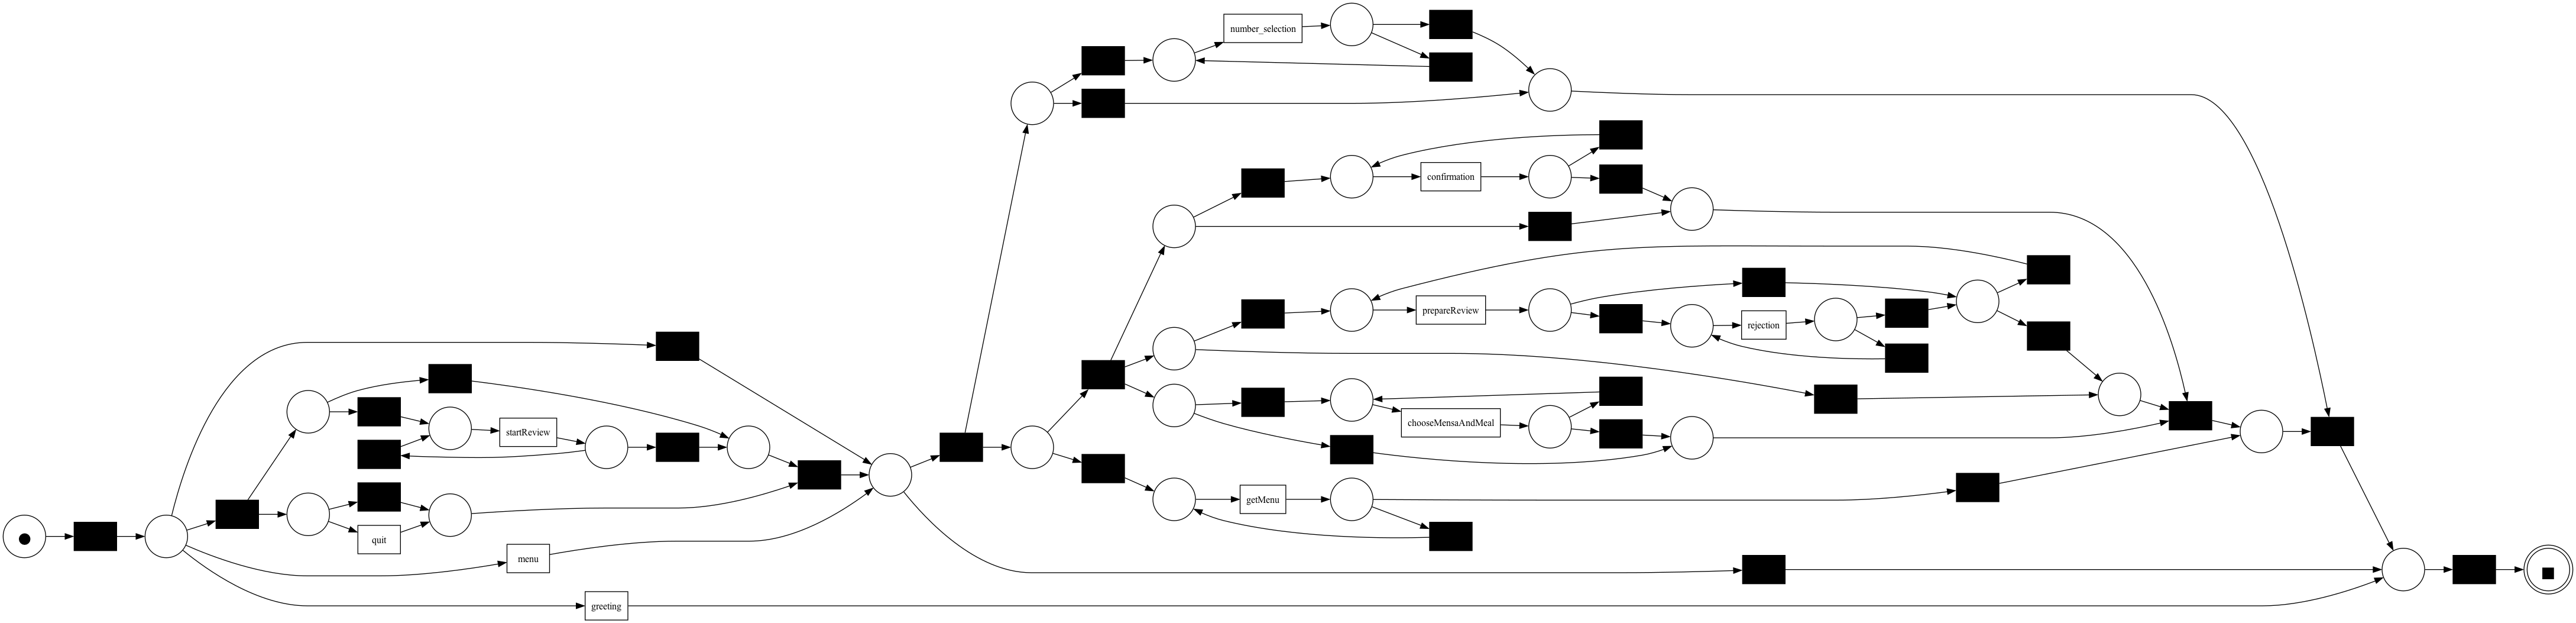

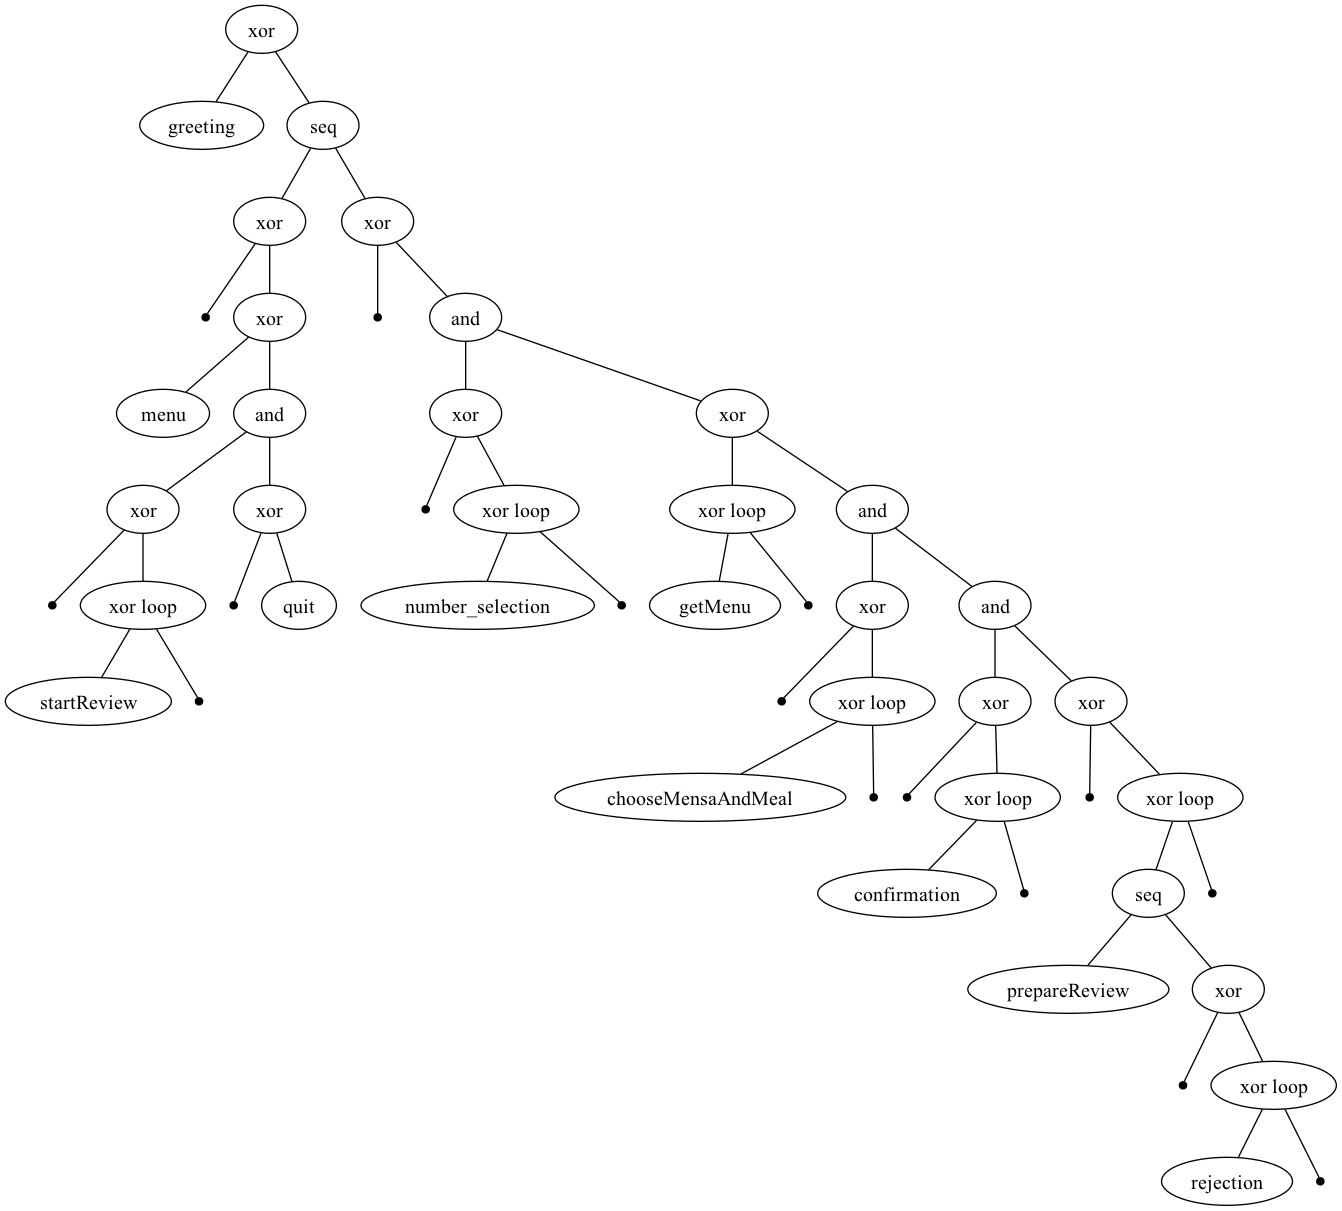

In [5]:
log = pm4py.filter_variants_top_k(log, 10)

net,im,fm = discovery.discover_petri_net(log)
pm4py.view_petri_net(net,im,fm)
process_tree = discovery.discover_process_tree(log)
pm4py.view_process_tree(process_tree)
# bpmn = process_discovery.discover_bpmn(log)
# pm4py.view_bpmn(bpmn)

In [6]:
traces = pm4py.get_variants(log)
traces

{('startReview', 'quit', 'startReview'): 1,
 ('startReview',
  'chooseMensaAndMeal',
  'prepareReview',
  'confirmation',
  'number_selection',
  'prepareReview'): 3,
 ('menu', 'getMenu'): 2,
 ('startReview',
  'chooseMensaAndMeal',
  'prepareReview',
  'confirmation',
  'rejection'): 1,
 ('confirmation',): 3,
 ('quit',): 2,
 ('menu', 'getMenu', 'number_selection', 'getMenu'): 2,
 ('greeting',): 3,
 ('startReview',
  'chooseMensaAndMeal',
  'prepareReview',
  'rejection',
  'confirmation',
  'chooseMensaAndMeal',
  'number_selection',
  'prepareReview',
  'prepareReview',
  'rejection',
  'confirmation',
  'chooseMensaAndMeal',
  'prepareReview',
  'confirmation',
  'number_selection',
  'prepareReview'): 1,
 ('startReview',
  'chooseMensaAndMeal',
  'prepareReview',
  'rejection',
  'rejection'): 1}

# Bot Model

Fetching bot model from https://mobsos.tech4comp.dbis.rwth-aachen.de/SBFManager/models/MensaBot


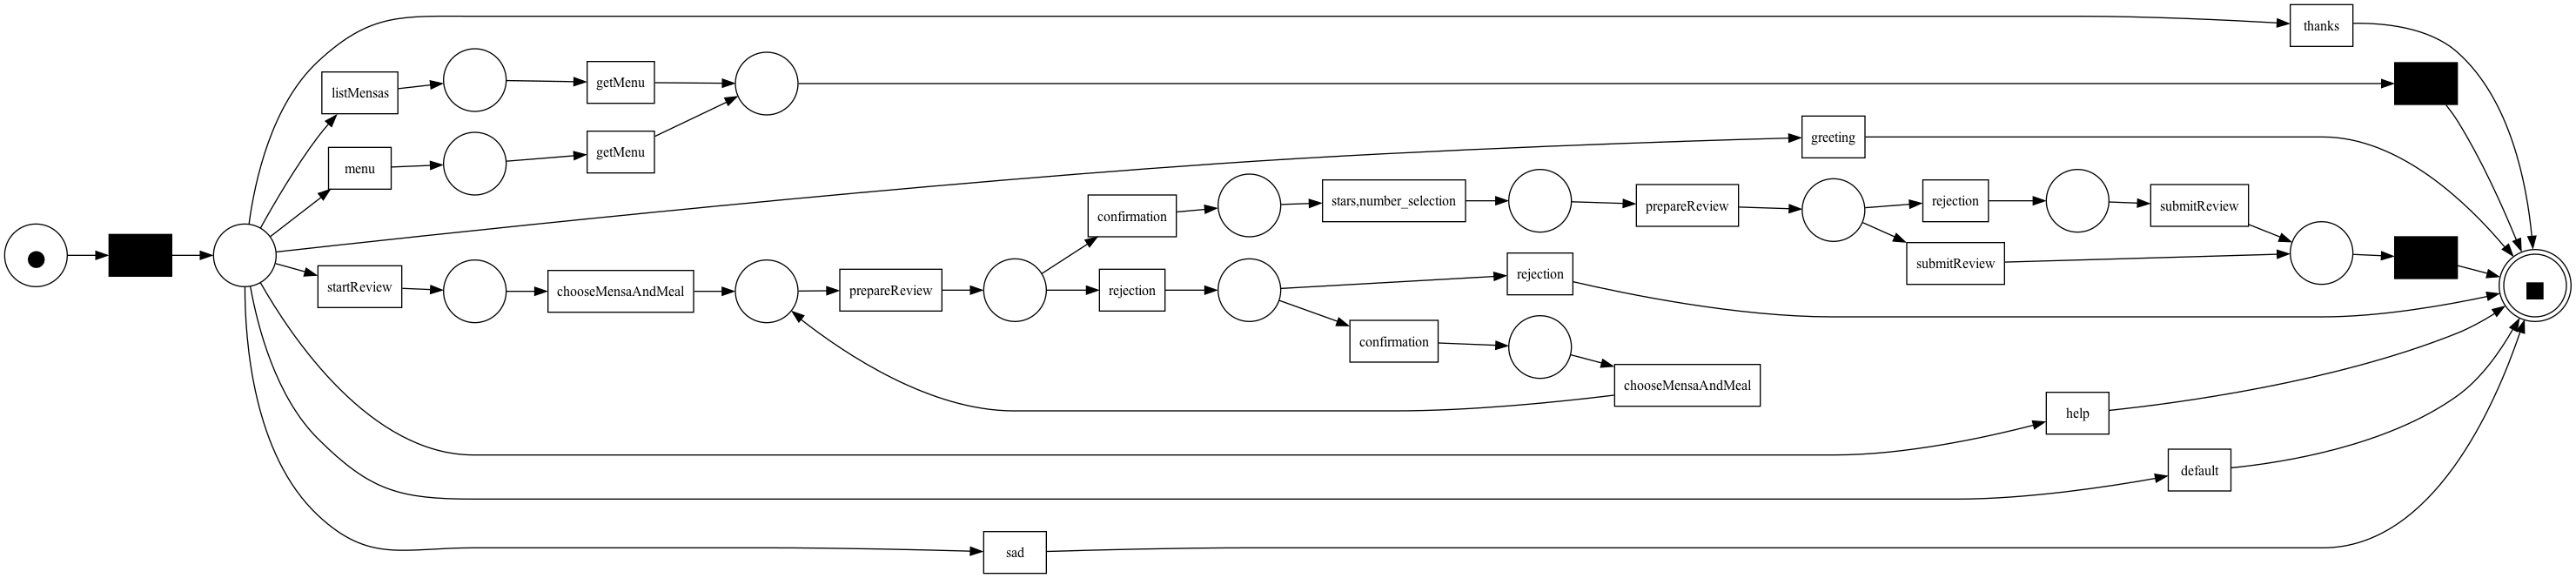

In [7]:
model = fetch_bot_model(bot_name,bot_manager_endpoint)
bp = get_parser(model)
bot_net,bot_im,bot_fm= bp.to_petri_net()
dfg,start_activities,end_activities = bp.get_dfg()
bot_net=pm4py.reduce_petri_net_invisibles(bot_net)
pm4py.view_petri_net(bot_net,bot_im,bot_fm)


In [8]:
unfitting_traces = cc.find_unfitting_traces(log, bot_net, bot_im, bot_fm)
missing_log_moves = list()
for trace in unfitting_traces:
    for move in trace['alignment']:
        if move[0] == ">>" and move[1]!= None:
            missing_log_moves.append(move[1])


aligning log, completed variants :: 100%|██████████| 10/10 [00:00<00:00, 281.64it/s]


In [9]:

print(f"Missing log moves: {missing_log_moves}")

Missing log moves: ['sad', 'stars,number_selection', 'submitReview', 'rejection', 'sad', 'sad', 'stars,number_selection', 'submitReview', 'sad', 'stars,number_selection', 'submitReview', 'sad', 'stars,number_selection', 'submitReview', 'sad']


aligning log, completed variants :: 100%|██████████| 10/10 [00:00<00:00, 174.38it/s]


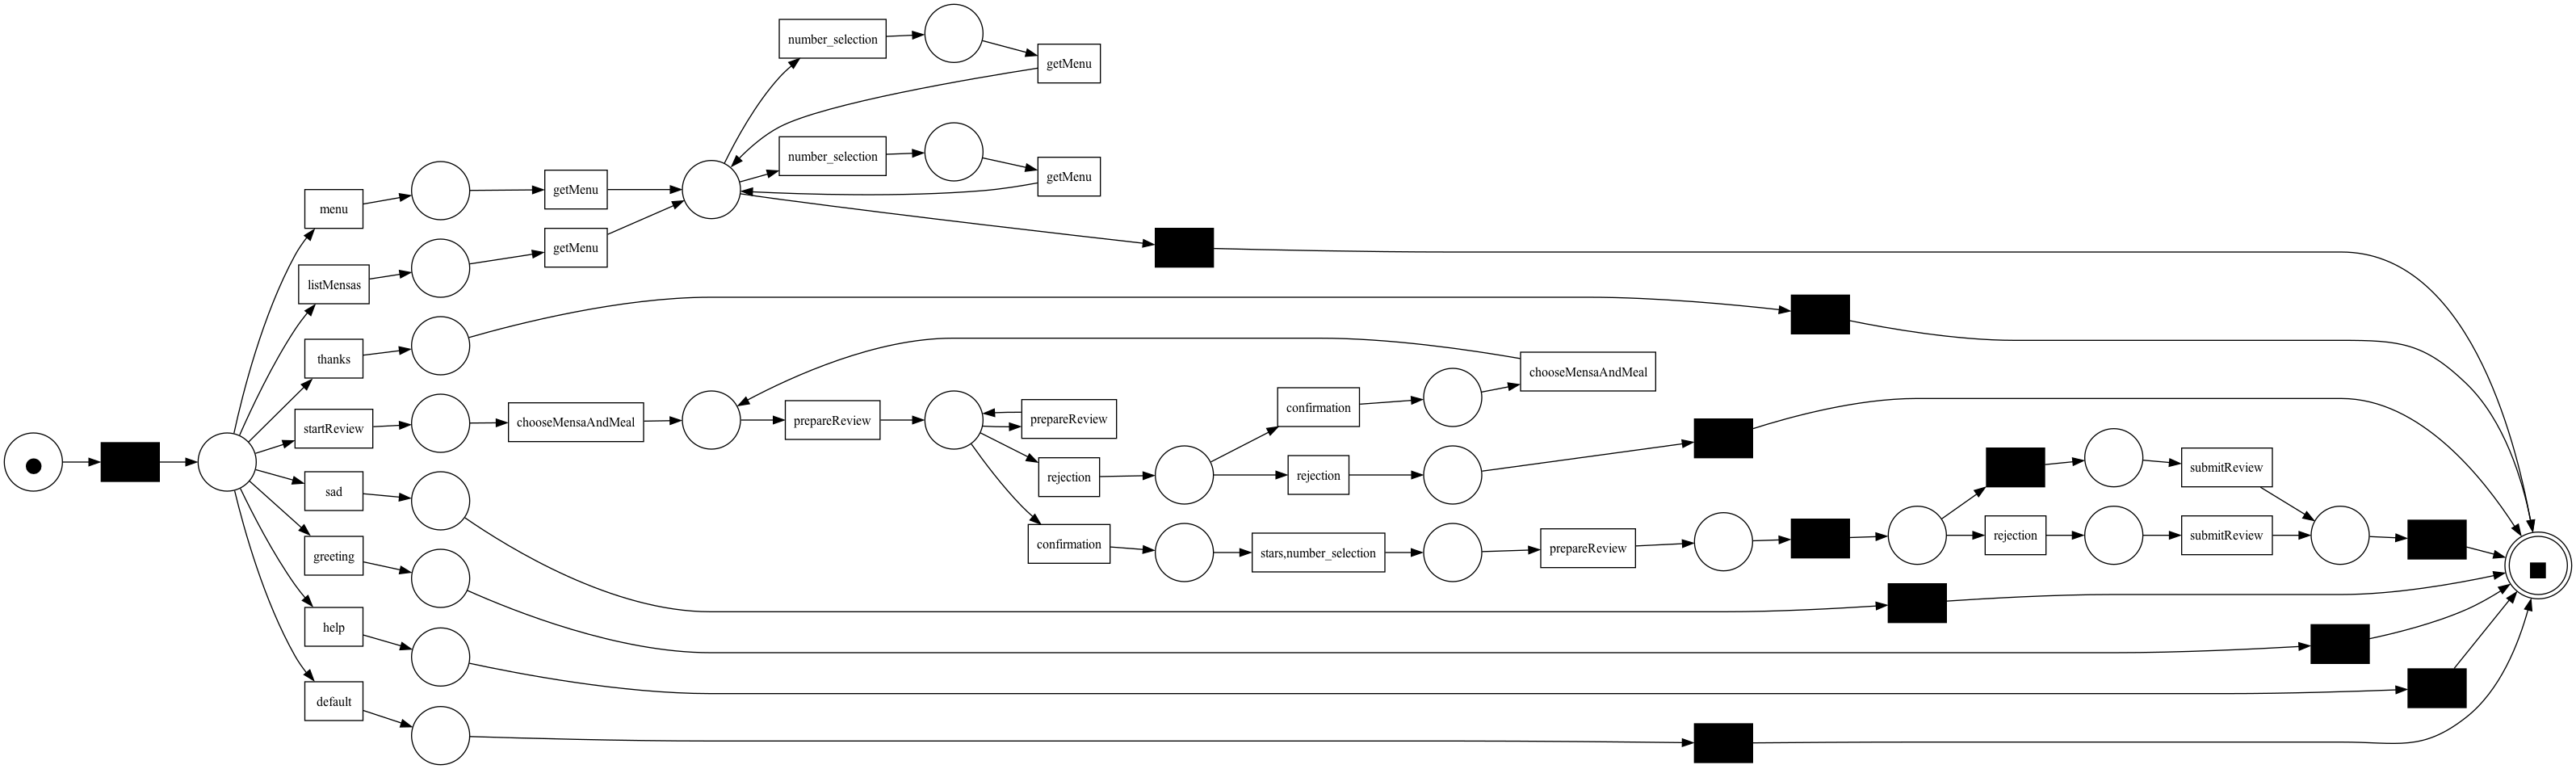

In [10]:
enhanced_model = enhancement.enhance_bot_model(log, dfg, bp)
bot_net,bot_im,bot_fm=bp.to_petri_net(enhanced_model,start_activities,end_activities)
pm4py.view_petri_net(bot_net,bot_im,bot_fm)